# **Neuro RLs** [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/TomGeorge1234/NeuroRLTutorial/blob/main/NeuroRL.ipynb)
### **University of Amsterdam Neuro-AI Summer School ,2024**
#### made by: **Tom George (UCL) and Jesse Geerts (Imperial)**

In this tutorial we'll study and build reinforcement learning models inspired by the brain. 

TODO: Insert fun animation of the model we'll end up building 

## **Learning Objectives**

## **Contents** 
0. [Import dependencies and data](#dependencies)
1. [Rescorla-Wagner Model](#rescorla)
2. [Temporal Difference Learning](#td)
3. [Q-Learning](#q)
    1. [Navigating in a grid world](#grid)
4. [Deep Q-Learning](#dqn)
    1. [Neuroscience inspired basis functions](#basis)

---
## **0. Import dependencies and data** <a name="dependencies"></a>
Run the following code: It'll install some dependencies, download some files and import some functions. You can mostly ignore it. 

In [22]:
import numpy as np 
import matplotlib.pyplot as plt 
import ratinabox
ratinabox.stylize_plots() # sets some RC params to make plots look better
# rc params to remove top and right spines from plot
from matplotlib import rcParams
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.xmargin'] = 0.05
plt.rcParams['axes.ymargin'] = 0.05

class BaseRescorlaWagner:
    def __init__(self, n_stimuli=1, alpha=0.1):
        self.n_stimuli = n_stimuli
        self.alpha = alpha
        self.V_history = []
        self.W_history = []
        self.R_history = []

    def plot(self, ax=None):
        if self.n_stimuli == 1:
            ax = self.plot_1d(ax)
        else:
            ax = self.plot_2d(ax)
        return ax 
        

    def plot_1d(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(3, 2)) 
        ax.scatter(np.arange(len(self.V_history)), self.V_history) 
        ax.set_xlabel('Trial')
        ax.set_ylabel('Value')
        return ax
    
    def plot_2d(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(3, 2)) 
        for i in range(self.n_stimuli):
            ax.scatter(np.arange(len(self.W_history)), self.W_history[:, i], label=f'Stimulus {i}')
        ax.set_xlabel('Trial')
        ax.set_ylabel('Association weight')
        ax.legend()
        return ax
    
    def save_history(self):
        self.V_history.append(self.V)
        self.R_history.append(self.R)
        if self.n_stimuli > 1:
            self.W_history.append(self.W)
        

---
## **1. Rescorla-Wagner** <a name="rescorla"></a>

Classical conditioning is where a neutral stimulus -- also called the _unconditioned stimulus, US_ -- is paired with a response-producing stimulus -- _the conditioned stimulus, CS_. After the association is learned, the neutral stimulus *alone* can produce the response.

The most famous example is Pavlov's dogs: Pavlov rang a bell before feeding his dogs which would cause them to salivate. After a while, the dogs would start salivating when they heard the bell, even if no food was presented.

In 1972 Rescorla and Wagner proposed a simple model to explain this learning process. The model is based on the idea that the strength of the association between the CS and US is proportional to the discrepancy between the expected and actual US.

### **1.1. Model**
Following on from the Pavlov's dogs example, let's say the bell is the conditioned stimulus, $CS$, and the food is the unconditioned stimulus, $US$ which comes with a response (reward) of strength $R$. The _value_ of the stimulus, $V$, is the strength of the association between the $i^{th}$ stimulus and the unconditioned response.

Mathematically, the model is defined as follows:

$$\Delta V = \alpha \cdot \delta$$
$$\delta = R - V$$

I.e. the increment in the value of the stimulus, $\Delta V$, is proportional to the discrepancy between the reward (the unconditioned response) that was recieved, $R$, and the value of the stimulus, $V$. The proportionality constant $\alpha$ is the learning rate.

**Exercise 1.1** 
1. Consider a simple example where there is only one stimulus with zero initial value. A constant reward, $R$ is given each trial. Show the value of the stimulus after the first trial is given by $V(1) = \alpha  \cdot R$.
2. Show the value of the stimulus should _exponentially_ decay towards the reward with a time constant $\tau = \frac{1}{\alpha} $. (_Hint: consider using the change of of variables $U(t) = R - V(t)$._)
I.e. show: 

$$V(t) = R \cdot (1 - e^{-\alpha\cdot t})$$

### **1.2 Model implementation**

Below we provide some basic code implementing a Rescorla Wagner model. 

**Exercise 1.2**
1. Complete the `def learn(self, R):` function to implement the Rescorla-Wagner learning rule. 


In [53]:
class RescorlaWagner(BaseRescorlaWagner):
    def __init__(self, alpha = 0.1,): 
        """alpha is the learning rate"""
        self.V = 0
        self.V_history = np.array([self.V])
        super().__init__(alpha=alpha)

    def learn(self, R):
        """R is the reward recieved on the current trial"""
        self.R = R
        raise NotImplementedError("You need to implement this method")
        # error = ???
        # self.V += ???
        # self.save_history() # call this pre-made function to save the history for later plotting. 


In [54]:
#@title Double click to see solution {display-mode: "form" }
class RescorlaWagner(BaseRescorlaWagner):
    def __init__(self, alpha = 0.1,): 
        """alpha is the learning rate"""
        self.V = 0
        self.V_history = np.array([self.V])
        super().__init__(alpha=alpha)

    def learn(self, R):
        """R is the reward recieved on the current trial"""
        self.R = R
        error = R - self.V
        self.V += self.alpha * error
        self.save_history() # call this pre-made function to save the history for later plotting. 


Now lets run an experiment where a reward of 1 is given each trial. We'll plot the value of the stimulus over time using the pre-written `RescorlaWagner.plot()` function.

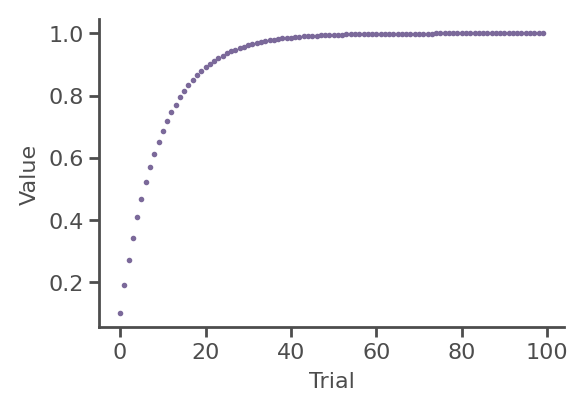

In [56]:
RW = RescorlaWagner(alpha=0.1)
for trial in range(100):
    RW.learn(R=1)
ax = RW.plot()

**Exercise 1.3**

Plot the theoretcial solution you derived earlier onto the `ax` and see if it fits.

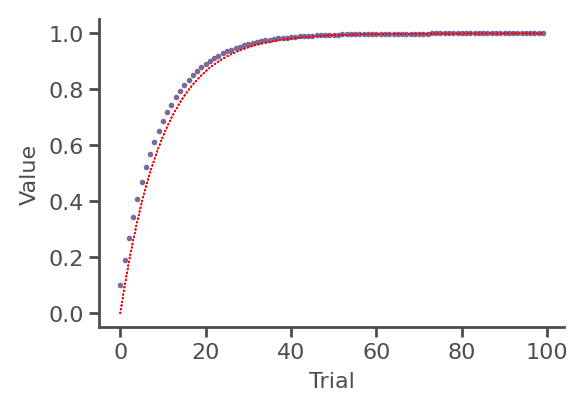

In [64]:
#@title Double click to see solution {display-mode: "form" }
t_range = np.arange(100)
R = 1
alpha = 0.1
V = R * (1 - np.exp(-t_range*alpha))
ax.plot(t, V, label='Theoretical', linewidth=0.5, color='r', linestyle=":")
ax.figure

**Exercise 1.4**

1. **Acquisition** Repeat the above experiment with a lower and a higher learning rate. What do you observe?
2. **Extinction** Repeat the above but this time reward is given only for the first 50 trials, then the reward is set to zero. What do you observe?


### **1.3. Rescorla-Wagner with multiple stimuli**

It's easy to extend the Rescorla-Wagner model to multiple stimuli:

* Multiple stimuli are represented by a vectors, e.g.:  
    * Stimulus A: $S = [1, 0]$ means there are 2 stimuli, only the first of which was present on this particular trial. 
    * Stimulus B: $S = [0, 1]$ means only the second stimulus was present.
    * Stimulus A & B: $S = [1, 1]$ means both stimuli were present.
* A vector of association "weights", $W$, denotes the strength of the association between each stimulus and the unconditioned response (i.e. the value of each stimulus). 
    * $W = [W_1, W_2]$.
* The total value of the stimuli is the sum of the values of each stimulus present on a given trial: 
$$ V = S \cdot W $$

The full Rescorla-Wagner model is then:
$$\delta \vec{W} = \alpha \cdot \big(R - V\big) \cdot \vec{S}$$

**Exercise 1.4**
1. Explain why $S$ now appears in the learning rule.

In [34]:
class RescorlaWagner_MultipleStimuli(BaseRescorlaWagner):
    def __init__(self, alpha = 0.1, n_stimuli=2): 
        """alpha is the learning rate"""
        self.alpha = alpha
        self.W = np.zeros(n_stimuli)
        self.W_history = np.array([self.W])
        super().__init__(alpha=alpha, 
                         n_stimuli=n_stimuli)

    def learn(self, S, R):
        """S is the stimulus vector. R is the reward recieved on the current trial"""
        self.V = S @ self.W
        self.R = R
        error = R - V
        self.W += self.alpha * S * error
        self.save_history(R)
        

**Exercise 1.4**:
1. With your partner implement these four experiments in the Rescorla-Wagner model:
    1. *Blocking*
        * A single stimulus is paired with the US (A --> R), then a compound stimulus is paired with the US (AB --> R). What happens?
    2. Overshadowing
        * Two stimuli are paired with a reward (AB --> R) but one is much more salient than the other, e.g. $S = [1, 0.1]$.
    3. Overexpectation
        * Two stimuli are seperately paired with the US (A --> R, B --> R), then the compound stimulus is presented (AB --> ?). What happens?

[9.99986719e-01 1.32806994e-05]


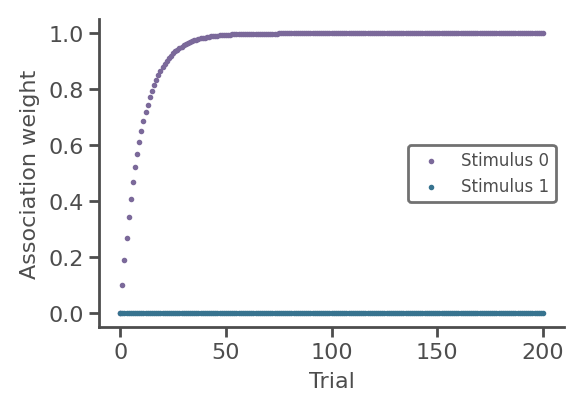

In [38]:
#@title Double click to see solution {display-mode: "form" }
RW = RescorlaWagner_MultipleStimuli(n_stimuli=2)
for i in range(100):
    RW.learn(S=np.array([1, 0]), R=1)
for i in range(100):
    RW.learn(S=np.array([1, 1]), R=1)
RW.plot()
print(RW.W)

[0.99007548 0.09900755]


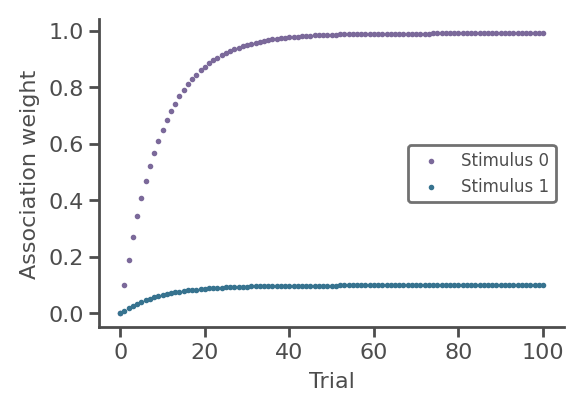

In [40]:
#@title Double click to see solution {display-mode: "form" }
RW = RescorlaWagner_MultipleStimuli(n_stimuli=2)
for i in range(100):
    RW.learn(S=np.array([1, 0.1]), R=1)
RW.plot()
print(RW.W)